In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
from sklearn.model_selection import train_test_split
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")


Using device: cuda


## Data set import

In [3]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def shuffle(self):
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
#data=loaded(t=13)
#data.applySobel()
#data.augment()

### gen data

In [8]:
def genData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_gel_15.npz")
    data.applySobel()
    #data2=loaded(to,filename="X_data_15.npz")
    #data2.applySobel()
    #data.X=np.concatenate([data.X,data2.X])
    #data.y=np.concatenate([data.y,data2.y])
    #del data2
    #data3=loaded(to,filename="X_data_gel_15.npz")
    #data3.applySobel()
    #data.X=np.concatenate([data.X,data3.X])
    #data.y=np.concatenate([data.y,data3.y])
    #del data3
    #data.resize(percentage)
    data.augment()
    #data.shuffle()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_data_newMorph.npz")
    #d.applySobel()
    #p20=d.X[np.where(d.y==3)]
    #data.X=np.concatenate([data.X,p20])
    #data.y=np.concatenate([data.y,np.zeros((len(p20)))+11])
    print("LOADED DATASET...")
    #data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to)*data.X.shape[2],data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader

def gen3DData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    data.resize(percentage)
    n=int(len(data.X)*0.6)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    #data=loaded(to,filename="X_data_newMorph.npz")
    #data.applySobel()
    data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    #data3=loaded(to,filename="X_data_gel_15.npz")
    #data3.applySobel()
    #data.X=np.concatenate([data.X,data2.X,data3.X])
    #data.y=np.concatenate([data.y,data2.y,data3.y])
    #del data2
    #del data3
    data.augment()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
    #d.applySobel()
    #data.augment()
    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to),data.X.shape[2]*data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genCNNLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data3=loaded(to,filename="X_data_gel_15.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data2.X,data3.X])
    data.y=np.concatenate([data.y,data2.y,data3.y])
    del data2
    del data3
    data.augment()

    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

## Model

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self,input_height, input_width,output=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten_size = 10 * (input_height // 4) * (input_width // 4)
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Simple3DCNN(nn.Module):
    def __init__(self, input_depth, input_height, input_width):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        depth = input_depth
        height = input_height
        width = input_width
        
        depth = depth // 2  # after first pooling
        height = height // 2
        width = width // 2
        
        depth = depth // 2  # after second pooling
        height = height // 2
        width = width // 2
        
        # Number of output features from conv layers (channels * depth * height * width)
        self.flatten_size = 10 * depth * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class CNN_LSTM(nn.Module):
    def __init__(self, input_width, input_height, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        )
        
        # Calculate the CNN output size
        cnn_output_size = self._get_cnn_output_size(input_width, input_height)
        
        # Define the LSTM part
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define the final fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def _get_cnn_output_size(self, width, height):
        # Create a dummy tensor with the given width and height
        dummy_input = torch.zeros(1, 1, height, width)
        
        # Pass the dummy tensor through the CNN
        dummy_output = self.cnn(dummy_input)
        
        # Calculate the output size by flattening the output
        return dummy_output.view(-1).size(0)
    
    def forward(self, x):
        batch_size, c, sequence_length, h, w = x.size()
        # Reshape input to (batch_size * sequence_length, c, h, w) for CNN
        c_in = x.view(batch_size * sequence_length, c, h, w)
        
        # Pass through CNN
        c_out = self.cnn(c_in)
        
        # Flatten the CNN output
        c_out = c_out.view(c_out.size(0), -1)
        
        # Reshape to (batch_size, sequence_length, cnn_output_size) for LSTM
        lstm_in = c_out.view(batch_size, sequence_length, -1)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(lstm_in)
        
        # Get the output from the last time step
        output = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        output = self.fc(output)
        
        return output
    


## Train

In [6]:
# Define the Loss Function and Optimizer
def run(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleCNN(image.shape[0],image.shape[1],output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def run3D(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    model = Simple3DCNN(image.shape[0],image.shape[1],image.shape[2]).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def calc(model,data_loader):
        correct=0
        summed=0.1
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            a=torch.argmax(outputs,axis=1)==torch.argmax(labels,axis=1)

            summed+=len(inputs)
            correct+=len(a[a==1])
        print("Accuracy:",(correct/summed)*100,"%")
        return correct/summed
def runLSTM(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleLSTM(image.shape[0],1000,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def runLSTMcnn(train_loader,frm,to,num_epochs=150):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = CNN_LSTM(image.shape[1],image.shape[0],1000,1,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

### CNN train

In [11]:
torch.cuda.empty_cache()
train_loader,test_loader=genData(0,4)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelgel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 12.0 GB
Using 2.48 GB
torch.Size([6300, 1, 440, 120])
torch.Size([6300, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_5632\3180350496.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 336.3205
Epoch [11/100], Step [126/126], Loss: 23.6452
Epoch [21/100], Step [126/126], Loss: 4.4718
Epoch [31/100], Step [126/126], Loss: 0.8237
Epoch [41/100], Step [126/126], Loss: 0.2947
Epoch [51/100], Step [126/126], Loss: 0.1932
Epoch [61/100], Step [126/126], Loss: 0.1390
Epoch [71/100], Step [126/126], Loss: 0.1066
Epoch [81/100], Step [126/126], Loss: 0.0865
Epoch [91/100], Step [126/126], Loss: 0.0735
Finished Training
Accuracy: 99.83334655979685 %
0.9983334655979685
Accuracy: 99.99801591238268 %
0.9999801591238269


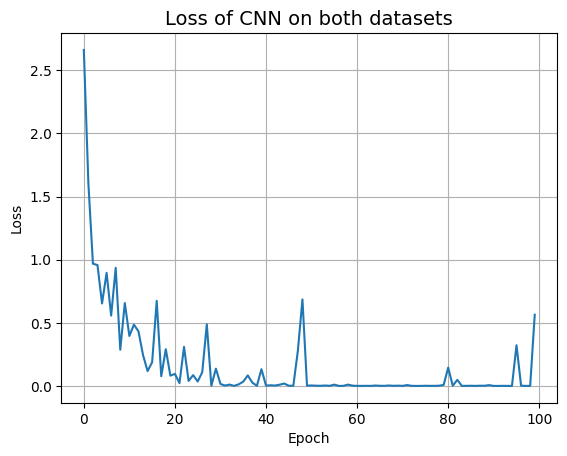

In [8]:
plt.plot(history)
plt.grid(True)
plt.title("Loss of CNN on both datasets",fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path+"/images/loss_of_uber_model.pdf")
plt.show()

In [48]:
train_loader,test_loader,unique=genData(0,4)
data=loaded(4,filename="X_data_newMorph.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=13).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()

Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (110, 120)
Memory needed: 0.38 GB
Memory left 1.93 GB
Using 2.15 GB
torch.Size([5460, 1, 440, 120])
torch.Size([5460, 13])


/tmp/ipykernel_21459/1734164554.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
  (relu): ReLU()
)

In [ ]:


ar=[]
acc=[]
for i in range(5):
    try:
        torch.cuda.empty_cache()
        train_loader,test_loader,unique=genData(0,4)
        model,history=run(train_loader,0,4)
        ar.append(history)
        print(calc(model,test_loader))
        print(calc(model,train_loader))
        acc.append(calc(model,test_loader))
        if acc[-1]>=max(acc):
            torch.save(model.state_dict(), path+"/model/mymmodel_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
    except MemoryError as e:
        try:
            del train_loader
            del test_loader
            del model
        except: 
            pass
ar=np.array(ar)
acc=np.array(acc)


np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/accuracies_of_NM_uber",acc)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/loss_of_NM_uber",ar)

NameError: name 'acc' is not defined

In [28]:
test_scores=np.zeros((10,14,3))
train_scores=np.zeros((10,14,3))
t_averages=np.zeros((10*14*3))

#test_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/test_scores.npy")
#train_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/train_scores.npy")
c=0
for i in range(1,10): #loop through frm dimention
    for j in range(i+1,15): #loop though to dimention
        print(">>>>",i,j,"\nMax:",np.max(test_scores)*100,"%","\nEstimated time left:",(np.average(t_averages[t_averages!=0])*len(t_averages[t_averages==0]))/60,"minutes")
        for trial in range(3):
            t=time.time()
            torch.cuda.empty_cache()
            train_loader,test_loader,__=genData(i,j)
            model=run(train_loader,i,j)
            test_scores[i][j-1][trial]=calc(model,test_loader)
            train_scores[i][j-1][trial]=calc(model,train_loader)
            torch.cuda.empty_cache()
            del train_loader
            del test_loader
            del model
            t2=time.time()
            t_averages[c]=t2-t
            c+=1
        clear_output(wait=True)
        np.save(path+"saves/test_scores_NM_",test_scores)
        np.save(path+"saves/train_scores_NM",train_scores)




/its/home/drs25/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/its/home/drs25/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


>>>> 1 2 
Max: 0.0 % 
Estimated time left: nan minutes
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 2 
Image: (110, 120)
Memory needed: 0.19 GB
Memory left 1.93 GB


ValueError: cannot reshape array of size 144144000 into shape (5460,1,110,120)

#### resolution

In [7]:

resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
scores_test=np.load(path+"/data/test_resolutions_uber.npy")#np.load(path+"/data/test_resolutions_uber.npy")#np.zeros((len(resolutions),3))
scores_test_NM=np.load(path+"/data/resolutions_uberNM.npy")#np.load(path+"/data/test_resolutions_NM.npy")#np.zeros((len(resolutions),3))
scores_train=np.load(path+"/data/train_resolutions_uber.npy")#np.load(path+"/data/train_resolutions_uber.npy")#np.zeros((len(resolutions),3))

try:
    for i, res in enumerate((resolutions[resolutions.index(0.25):])): #
        i+=resolutions.index(0.25)
        print("Testing resolution",res)
        for j in range(3): #three trials on each
            torch.cuda.empty_cache()
            train_loader,test_loader,unique=genData(0,4,res)
            model,history=run(train_loader,0,4,num_epochs = 130)
            test_acc=calc(model,test_loader)
            train_acc=calc(model,train_loader)
            #look at other stuff
            del train_loader
            del test_loader
            torch.cuda.empty_cache()
            d=loaded(t=4,filename="X_data_newMorph.npz")
            d.applySobel()
            d.resize(res)
            sample=d.X
            x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
            x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
            test=torch.tensor(x, dtype=torch.float32).to(device)
            preds=model(test)
            preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
            a=preds-d.y
            scores_test_NM[i][j]=len(a[a==0])/len(preds)
            scores_test[i][j]=test_acc
            scores_train[i][j]=train_acc
            print("\t\t",test_acc*100,"%",train_acc*100,"%",len(a[a==0])/len(preds) *100,"%")
            del model
            del d
            del preds
            del test
except Exception as e:
    print(e)
    print(res)
np.save(path+"/data/test_resolutions_uber",scores_test)
np.save(path+"/data/train_resolutions_uber",scores_train)
np.save(path+"/data/train_resolutions_uberNM",scores_test_NM)

Testing resolution 0.25
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 25800 
Window size: 4 
Image: (27, 30)
Memory needed: 0.08 GB
Memory left 12.0 GB
Using 0.44 GB
torch.Size([18060, 1, 108, 30])
torch.Size([18060, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 979.6498
Epoch [11/130], Step [362/362], Loss: 957.1443
Epoch [21/130], Step [362/362], Loss: 451.6282
Epoch [31/130], Step [362/362], Loss: 285.2444
Epoch [41/130], Step [362/362], Loss: 206.0982
Epoch [51/130], Step [362/362], Loss: 152.5546
Epoch [61/130], Step [362/362], Loss: 112.5645
Epoch [71/130], Step [362/362], Loss: 87.0443
Epoch [81/130], Step [362/362], Loss: 69.8416
Epoch [91/130], Step [362/362], Loss: 56.9289
Epoch [101/130], Step [362/362], Loss: 47.0079
Epoch [111/130], Step [362/362], Loss: 40.7073
Epoch [121/130], Step [362/362], Loss: 34.5977
Finished Training
Accuracy: 96.92422690401705 %
Accuracy: 97.27230570109565 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 96.92422690401705 % 97.27230570109565 % 60.23076923076923 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 979.7571
Epoch [11/130], Step [362/362], Loss: 951.3968
Epoch [21/130], Step [362/362], Loss: 406.4445
Epoch [31/130], Step [362/362], Loss: 246.7638
Epoch [41/130], Step [362/362], Loss: 166.3600
Epoch [51/130], Step [362/362], Loss: 118.2657
Epoch [61/130], Step [362/362], Loss: 89.5026
Epoch [71/130], Step [362/362], Loss: 67.8569
Epoch [81/130], Step [362/362], Loss: 53.1718
Epoch [91/130], Step [362/362], Loss: 44.1522
Epoch [101/130], Step [362/362], Loss: 37.2524
Epoch [111/130], Step [362/362], Loss: 30.3148
Epoch [121/130], Step [362/362], Loss: 26.6249
Finished Training
Accuracy: 98.50225630519643 %
Accuracy: 98.76731196489503 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.50225630519643 % 98.76731196489503 % 69.0 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size:

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 979.3781
Epoch [11/130], Step [362/362], Loss: 962.7537
Epoch [21/130], Step [362/362], Loss: 512.1616
Epoch [31/130], Step [362/362], Loss: 321.4187
Epoch [41/130], Step [362/362], Loss: 235.4805
Epoch [51/130], Step [362/362], Loss: 175.6528
Epoch [61/130], Step [362/362], Loss: 135.8832
Epoch [71/130], Step [362/362], Loss: 103.9844
Epoch [81/130], Step [362/362], Loss: 83.3445
Epoch [91/130], Step [362/362], Loss: 67.2560
Epoch [101/130], Step [362/362], Loss: 56.9136
Epoch [111/130], Step [362/362], Loss: 48.2827
Epoch [121/130], Step [362/362], Loss: 41.6598
Finished Training
Accuracy: 96.25979347194153 %
Accuracy: 96.29639883444881 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 96.25979347194153 % 96.29639883444881 % 34.15384615384615 %
Testing resolution 0.3
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.6993
Epoch [11/130], Step [362/362], Loss: 717.8599
Epoch [21/130], Step [362/362], Loss: 307.6870
Epoch [31/130], Step [362/362], Loss: 208.0308
Epoch [41/130], Step [362/362], Loss: 147.7474
Epoch [51/130], Step [362/362], Loss: 106.2107
Epoch [61/130], Step [362/362], Loss: 81.7804
Epoch [71/130], Step [362/362], Loss: 63.0318
Epoch [81/130], Step [362/362], Loss: 49.1448
Epoch [91/130], Step [362/362], Loss: 43.1769
Epoch [101/130], Step [362/362], Loss: 35.6940
Epoch [111/130], Step [362/362], Loss: 31.2484
Epoch [121/130], Step [362/362], Loss: 24.7277
Finished Training
Accuracy: 96.8688574513441 %
Accuracy: 97.20309244814197 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 96.8688574513441 % 97.20309244814197 % 46.15384615384615 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
W

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 979.1525
Epoch [11/130], Step [362/362], Loss: 959.1130
Epoch [21/130], Step [362/362], Loss: 379.4386
Epoch [31/130], Step [362/362], Loss: 212.5843
Epoch [41/130], Step [362/362], Loss: 137.0884
Epoch [51/130], Step [362/362], Loss: 96.6773
Epoch [61/130], Step [362/362], Loss: 70.5083
Epoch [71/130], Step [362/362], Loss: 54.5398
Epoch [81/130], Step [362/362], Loss: 44.4624
Epoch [91/130], Step [362/362], Loss: 36.6494
Epoch [101/130], Step [362/362], Loss: 32.6845
Epoch [111/130], Step [362/362], Loss: 26.8296
Epoch [121/130], Step [362/362], Loss: 21.8056
Finished Training
Accuracy: 96.42590182996041 %
Accuracy: 97.11311521930219 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 96.42590182996041 % 97.11311521930219 % 73.23076923076923 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 


C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 979.7017
Epoch [11/130], Step [362/362], Loss: 959.9146
Epoch [21/130], Step [362/362], Loss: 407.4022
Epoch [31/130], Step [362/362], Loss: 230.9027
Epoch [41/130], Step [362/362], Loss: 150.5578
Epoch [51/130], Step [362/362], Loss: 105.0753
Epoch [61/130], Step [362/362], Loss: 76.9030
Epoch [71/130], Step [362/362], Loss: 56.5018
Epoch [81/130], Step [362/362], Loss: 46.6149
Epoch [91/130], Step [362/362], Loss: 38.1228
Epoch [101/130], Step [362/362], Loss: 30.8712
Epoch [111/130], Step [362/362], Loss: 26.4588
Epoch [121/130], Step [362/362], Loss: 22.9330
Finished Training
Accuracy: 98.28077849450459 %
Accuracy: 98.34511112187762 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.28077849450459 % 98.34511112187762 % 66.15384615384615 %
Testing resolution 0.35
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.7

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.5329
Epoch [11/130], Step [362/362], Loss: 565.1071
Epoch [21/130], Step [362/362], Loss: 265.5165
Epoch [31/130], Step [362/362], Loss: 161.4866
Epoch [41/130], Step [362/362], Loss: 103.9814
Epoch [51/130], Step [362/362], Loss: 72.7268
Epoch [61/130], Step [362/362], Loss: 54.9078
Epoch [71/130], Step [362/362], Loss: 44.6765
Epoch [81/130], Step [362/362], Loss: 35.7345
Epoch [91/130], Step [362/362], Loss: 28.7796
Epoch [101/130], Step [362/362], Loss: 24.7548
Epoch [111/130], Step [362/362], Loss: 21.6070
Epoch [121/130], Step [362/362], Loss: 17.6379
Finished Training
Accuracy: 98.08698541014923 %
Accuracy: 98.38663907364982 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.08698541014923 % 98.38663907364982 % 58.15384615384615 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 


C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.5708
Epoch [11/130], Step [362/362], Loss: 536.6364
Epoch [21/130], Step [362/362], Loss: 255.1618
Epoch [31/130], Step [362/362], Loss: 157.0579
Epoch [41/130], Step [362/362], Loss: 103.8484
Epoch [51/130], Step [362/362], Loss: 75.7837
Epoch [61/130], Step [362/362], Loss: 56.6328
Epoch [71/130], Step [362/362], Loss: 46.2119
Epoch [81/130], Step [362/362], Loss: 38.6801
Epoch [91/130], Step [362/362], Loss: 29.9949
Epoch [101/130], Step [362/362], Loss: 27.1771
Epoch [111/130], Step [362/362], Loss: 24.3037
Epoch [121/130], Step [362/362], Loss: 21.1499
Finished Training
Accuracy: 98.22540904183163 %
Accuracy: 98.16515666419807 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.22540904183163 % 98.16515666419807 % 55.92307692307692 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 


C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 979.1708
Epoch [11/130], Step [362/362], Loss: 906.9208
Epoch [21/130], Step [362/362], Loss: 306.9193
Epoch [31/130], Step [362/362], Loss: 173.8934
Epoch [41/130], Step [362/362], Loss: 112.6002
Epoch [51/130], Step [362/362], Loss: 78.7702
Epoch [61/130], Step [362/362], Loss: 59.9681
Epoch [71/130], Step [362/362], Loss: 46.3805
Epoch [81/130], Step [362/362], Loss: 37.2111
Epoch [91/130], Step [362/362], Loss: 31.3709
Epoch [101/130], Step [362/362], Loss: 26.6469
Epoch [111/130], Step [362/362], Loss: 22.8068
Epoch [121/130], Step [362/362], Loss: 19.0999
Finished Training
Accuracy: 98.22540904183163 %
Accuracy: 98.7534693143043 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.22540904183163 % 98.7534693143043 % 64.73076923076924 %
Testing resolution 0.4
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.4737
Epoch [11/130], Step [362/362], Loss: 413.4342
Epoch [21/130], Step [362/362], Loss: 211.0188
Epoch [31/130], Step [362/362], Loss: 130.2449
Epoch [41/130], Step [362/362], Loss: 90.7756
Epoch [51/130], Step [362/362], Loss: 67.5336
Epoch [61/130], Step [362/362], Loss: 51.6407
Epoch [71/130], Step [362/362], Loss: 41.2084
Epoch [81/130], Step [362/362], Loss: 33.3929
Epoch [91/130], Step [362/362], Loss: 25.8484
Epoch [101/130], Step [362/362], Loss: 23.4694
Epoch [111/130], Step [362/362], Loss: 20.3414
Epoch [121/130], Step [362/362], Loss: 16.0397
Finished Training
Accuracy: 97.75476869411146 %
Accuracy: 97.6875852188177 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 97.75476869411146 % 97.6875852188177 % 72.92307692307692 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Win

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.2717
Epoch [11/130], Step [362/362], Loss: 440.5594
Epoch [21/130], Step [362/362], Loss: 209.4223
Epoch [31/130], Step [362/362], Loss: 125.1616
Epoch [41/130], Step [362/362], Loss: 82.5422
Epoch [51/130], Step [362/362], Loss: 58.3676
Epoch [61/130], Step [362/362], Loss: 44.1121
Epoch [71/130], Step [362/362], Loss: 34.4731
Epoch [81/130], Step [362/362], Loss: 27.7959
Epoch [91/130], Step [362/362], Loss: 20.3606
Epoch [101/130], Step [362/362], Loss: 18.3013
Epoch [111/130], Step [362/362], Loss: 17.8993
Epoch [121/130], Step [362/362], Loss: 13.5572
Finished Training
Accuracy: 97.6993992414385 %
Accuracy: 97.80524774883894 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 97.6993992414385 % 97.80524774883894 % 88.5 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 979.4015
Epoch [11/130], Step [362/362], Loss: 618.2019
Epoch [21/130], Step [362/362], Loss: 234.3691
Epoch [31/130], Step [362/362], Loss: 133.8433
Epoch [41/130], Step [362/362], Loss: 86.9021
Epoch [51/130], Step [362/362], Loss: 61.9458
Epoch [61/130], Step [362/362], Loss: 47.7906
Epoch [71/130], Step [362/362], Loss: 35.3040
Epoch [81/130], Step [362/362], Loss: 29.3080
Epoch [91/130], Step [362/362], Loss: 22.7788
Epoch [101/130], Step [362/362], Loss: 18.5914
Epoch [111/130], Step [362/362], Loss: 17.3017
Epoch [121/130], Step [362/362], Loss: 13.9713
Finished Training
Accuracy: 98.28077849450459 %
Accuracy: 98.67041341075989 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.28077849450459 % 98.67041341075989 % 61.30769230769231 %
Testing resolution 0.45
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 977.7987
Epoch [11/130], Step [362/362], Loss: 361.6784
Epoch [21/130], Step [362/362], Loss: 174.5517
Epoch [31/130], Step [362/362], Loss: 107.4292
Epoch [41/130], Step [362/362], Loss: 74.3880
Epoch [51/130], Step [362/362], Loss: 54.2426
Epoch [61/130], Step [362/362], Loss: 41.8403
Epoch [71/130], Step [362/362], Loss: 34.6282
Epoch [81/130], Step [362/362], Loss: 27.1676
Epoch [91/130], Step [362/362], Loss: 21.8882
Epoch [101/130], Step [362/362], Loss: 19.4223
Epoch [111/130], Step [362/362], Loss: 16.8598
Epoch [121/130], Step [362/362], Loss: 15.1645
Finished Training
Accuracy: 99.00058137925308 %
Accuracy: 99.29333268734297 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 99.00058137925308 % 99.29333268734297 % 68.1923076923077 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Wi

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.3164
Epoch [11/130], Step [362/362], Loss: 384.8735
Epoch [21/130], Step [362/362], Loss: 189.5782
Epoch [31/130], Step [362/362], Loss: 115.4860
Epoch [41/130], Step [362/362], Loss: 77.5693
Epoch [51/130], Step [362/362], Loss: 57.1200
Epoch [61/130], Step [362/362], Loss: 45.3036
Epoch [71/130], Step [362/362], Loss: 36.3820
Epoch [81/130], Step [362/362], Loss: 29.6776
Epoch [91/130], Step [362/362], Loss: 24.8801
Epoch [101/130], Step [362/362], Loss: 21.3186
Epoch [111/130], Step [362/362], Loss: 18.1520
Epoch [121/130], Step [362/362], Loss: 16.2478
Finished Training
Accuracy: 98.52994103153291 %
Accuracy: 99.03724365141437 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.52994103153291 % 99.03724365141437 % 71.15384615384616 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
W

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 977.4311
Epoch [11/130], Step [362/362], Loss: 417.6783
Epoch [21/130], Step [362/362], Loss: 186.3662
Epoch [31/130], Step [362/362], Loss: 107.7139
Epoch [41/130], Step [362/362], Loss: 72.3006
Epoch [51/130], Step [362/362], Loss: 50.7319
Epoch [61/130], Step [362/362], Loss: 38.9798
Epoch [71/130], Step [362/362], Loss: 30.1991
Epoch [81/130], Step [362/362], Loss: 24.1546
Epoch [91/130], Step [362/362], Loss: 21.5657
Epoch [101/130], Step [362/362], Loss: 17.9409
Epoch [111/130], Step [362/362], Loss: 15.6613
Epoch [121/130], Step [362/362], Loss: 14.0843
Finished Training
Accuracy: 97.94856177846682 %
Accuracy: 98.0059661824046 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 97.94856177846682 % 98.0059661824046 % 78.76923076923077 %
Testing resolution 0.5
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 976.5048
Epoch [11/130], Step [362/362], Loss: 309.0960
Epoch [21/130], Step [362/362], Loss: 133.7704
Epoch [31/130], Step [362/362], Loss: 79.0031
Epoch [41/130], Step [362/362], Loss: 51.7533
Epoch [51/130], Step [362/362], Loss: 36.0547
Epoch [61/130], Step [362/362], Loss: 28.2351
Epoch [71/130], Step [362/362], Loss: 22.0631
Epoch [81/130], Step [362/362], Loss: 18.6089
Epoch [91/130], Step [362/362], Loss: 14.5404
Epoch [101/130], Step [362/362], Loss: 12.7387
Epoch [111/130], Step [362/362], Loss: 10.6601
Epoch [121/130], Step [362/362], Loss: 8.2296
Finished Training
Accuracy: 99.0836355582625 %
Accuracy: 99.17567015732173 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 99.0836355582625 % 99.17567015732173 % 84.11538461538461 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Windo

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.1575
Epoch [11/130], Step [362/362], Loss: 324.4628
Epoch [21/130], Step [362/362], Loss: 147.5206
Epoch [31/130], Step [362/362], Loss: 89.8554
Epoch [41/130], Step [362/362], Loss: 59.7348
Epoch [51/130], Step [362/362], Loss: 43.7796
Epoch [61/130], Step [362/362], Loss: 33.2716
Epoch [71/130], Step [362/362], Loss: 27.6091
Epoch [81/130], Step [362/362], Loss: 22.1293
Epoch [91/130], Step [362/362], Loss: 16.9281
Epoch [101/130], Step [362/362], Loss: 14.0370
Epoch [111/130], Step [362/362], Loss: 11.7310
Epoch [121/130], Step [362/362], Loss: 11.2626
Finished Training
Accuracy: 99.36048282162731 %
Accuracy: 99.41791654265958 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 99.36048282162731 % 99.41791654265958 % 83.92307692307692 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Wi

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 977.3562
Epoch [11/130], Step [362/362], Loss: 308.3090
Epoch [21/130], Step [362/362], Loss: 139.0975
Epoch [31/130], Step [362/362], Loss: 81.3656
Epoch [41/130], Step [362/362], Loss: 54.3119
Epoch [51/130], Step [362/362], Loss: 37.7732
Epoch [61/130], Step [362/362], Loss: 28.7255
Epoch [71/130], Step [362/362], Loss: 23.5418
Epoch [81/130], Step [362/362], Loss: 19.5215
Epoch [91/130], Step [362/362], Loss: 16.3203
Epoch [101/130], Step [362/362], Loss: 13.8386
Epoch [111/130], Step [362/362], Loss: 12.0828
Epoch [121/130], Step [362/362], Loss: 9.9933
Finished Training
Accuracy: 98.64067993687883 %
Accuracy: 99.27256871145687 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.64067993687883 % 99.27256871145687 % 72.42307692307692 %
Testing resolution 0.55
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 977.9018
Epoch [11/130], Step [362/362], Loss: 283.5657
Epoch [21/130], Step [362/362], Loss: 120.2088
Epoch [31/130], Step [362/362], Loss: 71.5305
Epoch [41/130], Step [362/362], Loss: 47.2831
Epoch [51/130], Step [362/362], Loss: 34.6208
Epoch [61/130], Step [362/362], Loss: 26.1184
Epoch [71/130], Step [362/362], Loss: 22.1635
Epoch [81/130], Step [362/362], Loss: 16.8699
Epoch [91/130], Step [362/362], Loss: 15.1033
Epoch [101/130], Step [362/362], Loss: 12.1602
Epoch [111/130], Step [362/362], Loss: 10.7985
Epoch [121/130], Step [362/362], Loss: 9.8280
Finished Training
Accuracy: 99.38816754796379 %
Accuracy: 99.62555630152062 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 99.38816754796379 % 99.62555630152062 % 70.84615384615385 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Win

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.1875
Epoch [11/130], Step [362/362], Loss: 291.0254
Epoch [21/130], Step [362/362], Loss: 131.2362
Epoch [31/130], Step [362/362], Loss: 79.1940
Epoch [41/130], Step [362/362], Loss: 52.6086
Epoch [51/130], Step [362/362], Loss: 39.4215
Epoch [61/130], Step [362/362], Loss: 30.6821
Epoch [71/130], Step [362/362], Loss: 24.9054
Epoch [81/130], Step [362/362], Loss: 19.5107
Epoch [91/130], Step [362/362], Loss: 16.5100
Epoch [101/130], Step [362/362], Loss: 15.0088
Epoch [111/130], Step [362/362], Loss: 13.5232
Epoch [121/130], Step [362/362], Loss: 11.7452
Finished Training
Accuracy: 98.22540904183163 %
Accuracy: 98.61504280839695 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.22540904183163 % 98.61504280839695 % 73.5 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.9018
Epoch [11/130], Step [362/362], Loss: 309.4779
Epoch [21/130], Step [362/362], Loss: 142.0664
Epoch [31/130], Step [362/362], Loss: 84.3175
Epoch [41/130], Step [362/362], Loss: 58.1762
Epoch [51/130], Step [362/362], Loss: 43.1070
Epoch [61/130], Step [362/362], Loss: 33.3884
Epoch [71/130], Step [362/362], Loss: 24.7242
Epoch [81/130], Step [362/362], Loss: 20.3818
Epoch [91/130], Step [362/362], Loss: 15.6774
Epoch [101/130], Step [362/362], Loss: 14.2673
Epoch [111/130], Step [362/362], Loss: 11.8083
Epoch [121/130], Step [362/362], Loss: 10.5081
Finished Training
Accuracy: 96.42590182996041 %
Accuracy: 96.69091437628477 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 96.42590182996041 % 96.69091437628477 % 78.03846153846153 %
Testing resolution 0.6
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 977.7391
Epoch [11/130], Step [362/362], Loss: 277.6053
Epoch [21/130], Step [362/362], Loss: 122.8844
Epoch [31/130], Step [362/362], Loss: 72.0418
Epoch [41/130], Step [362/362], Loss: 46.3718
Epoch [51/130], Step [362/362], Loss: 31.9119
Epoch [61/130], Step [362/362], Loss: 22.2223
Epoch [71/130], Step [362/362], Loss: 17.8481
Epoch [81/130], Step [362/362], Loss: 14.0003
Epoch [91/130], Step [362/362], Loss: 12.3870
Epoch [101/130], Step [362/362], Loss: 9.0886
Epoch [111/130], Step [362/362], Loss: 7.8450
Epoch [121/130], Step [362/362], Loss: 5.7164
Finished Training
Accuracy: 98.8067882948977 %
Accuracy: 98.48353762778497 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.8067882948977 % 98.48353762778497 % 81.57692307692308 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window 

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 977.3855
Epoch [11/130], Step [362/362], Loss: 250.5276
Epoch [21/130], Step [362/362], Loss: 113.3819
Epoch [31/130], Step [362/362], Loss: 66.2454
Epoch [41/130], Step [362/362], Loss: 44.8718
Epoch [51/130], Step [362/362], Loss: 34.0319
Epoch [61/130], Step [362/362], Loss: 26.1139
Epoch [71/130], Step [362/362], Loss: 19.3592
Epoch [81/130], Step [362/362], Loss: 15.2582
Epoch [91/130], Step [362/362], Loss: 14.1820
Epoch [101/130], Step [362/362], Loss: 9.6374
Epoch [111/130], Step [362/362], Loss: 9.2294
Epoch [121/130], Step [362/362], Loss: 8.6475
Finished Training
Accuracy: 98.6683646632153 %
Accuracy: 98.86421051903018 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.6683646632153 % 98.86421051903018 % 80.34615384615384 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window 

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 978.7920
Epoch [11/130], Step [362/362], Loss: 265.8520
Epoch [21/130], Step [362/362], Loss: 119.9997
Epoch [31/130], Step [362/362], Loss: 70.7113
Epoch [41/130], Step [362/362], Loss: 46.2021
Epoch [51/130], Step [362/362], Loss: 34.1074
Epoch [61/130], Step [362/362], Loss: 25.1794
Epoch [71/130], Step [362/362], Loss: 19.3060
Epoch [81/130], Step [362/362], Loss: 15.4022
Epoch [91/130], Step [362/362], Loss: 12.3898
Epoch [101/130], Step [362/362], Loss: 10.2994
Epoch [111/130], Step [362/362], Loss: 9.7015
Epoch [121/130], Step [362/362], Loss: 7.2405
Finished Training
Accuracy: 99.69269953766508 %
Accuracy: 99.81243208449554 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 99.69269953766508 % 99.81243208449554 % 64.6923076923077 %
Testing resolution 0.7
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Da

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 977.0137
Epoch [11/130], Step [362/362], Loss: 211.3803
Epoch [21/130], Step [362/362], Loss: 89.1929
Epoch [31/130], Step [362/362], Loss: 50.7428
Epoch [41/130], Step [362/362], Loss: 34.8002
Epoch [51/130], Step [362/362], Loss: 25.1742
Epoch [61/130], Step [362/362], Loss: 18.0666
Epoch [71/130], Step [362/362], Loss: 13.3097
Epoch [81/130], Step [362/362], Loss: 11.7679
Epoch [91/130], Step [362/362], Loss: 8.9139
Epoch [101/130], Step [362/362], Loss: 7.5701
Epoch [111/130], Step [362/362], Loss: 7.5262
Epoch [121/130], Step [362/362], Loss: 5.4771
Finished Training
Accuracy: 98.97289665291659 %
Accuracy: 99.39715256677349 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 98.97289665291659 % 99.39715256677349 % 76.03846153846155 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window 

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 977.8482
Epoch [11/130], Step [362/362], Loss: 245.1940
Epoch [21/130], Step [362/362], Loss: 91.4748
Epoch [31/130], Step [362/362], Loss: 50.5964
Epoch [41/130], Step [362/362], Loss: 30.3295
Epoch [51/130], Step [362/362], Loss: 21.5642
Epoch [61/130], Step [362/362], Loss: 16.1194
Epoch [71/130], Step [362/362], Loss: 11.4524
Epoch [81/130], Step [362/362], Loss: 9.7280
Epoch [91/130], Step [362/362], Loss: 7.4731
Epoch [101/130], Step [362/362], Loss: 5.8960
Epoch [111/130], Step [362/362], Loss: 4.9630
Epoch [121/130], Step [362/362], Loss: 4.1341
Finished Training
Accuracy: 99.19437446360843 %
Accuracy: 99.50789377149937 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 99.19437446360843 % 99.50789377149937 % 81.6923076923077 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window si

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 971.8180
Epoch [11/130], Step [362/362], Loss: 208.0057
Epoch [21/130], Step [362/362], Loss: 93.3964
Epoch [31/130], Step [362/362], Loss: 53.0409
Epoch [41/130], Step [362/362], Loss: 35.2628
Epoch [51/130], Step [362/362], Loss: 25.7874
Epoch [61/130], Step [362/362], Loss: 18.7182
Epoch [71/130], Step [362/362], Loss: 14.1183
Epoch [81/130], Step [362/362], Loss: 11.4315
Epoch [91/130], Step [362/362], Loss: 9.3296
Epoch [101/130], Step [362/362], Loss: 6.5551
Epoch [111/130], Step [362/362], Loss: 6.7253
Epoch [121/130], Step [362/362], Loss: 5.2764
Finished Training
Accuracy: 99.69269953766508 %
Accuracy: 99.90933063863068 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
		 99.69269953766508 % 99.90933063863068 % 86.46153846153845 %
Testing resolution 0.8
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Data

C:\Users\dexte\AppData\Local\Temp\ipykernel_7488\55010018.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [362/362], Loss: 975.6732
Epoch [11/130], Step [362/362], Loss: 174.3907
Epoch [21/130], Step [362/362], Loss: 71.3905
Epoch [31/130], Step [362/362], Loss: 42.2562
Epoch [41/130], Step [362/362], Loss: 26.2509
Epoch [51/130], Step [362/362], Loss: 17.5144
Epoch [61/130], Step [362/362], Loss: 13.0907
Epoch [71/130], Step [362/362], Loss: 10.0856
Epoch [81/130], Step [362/362], Loss: 8.6041
Epoch [91/130], Step [362/362], Loss: 6.6687
Epoch [101/130], Step [362/362], Loss: 5.3678
Epoch [111/130], Step [362/362], Loss: 4.3839
Epoch [121/130], Step [362/362], Loss: 3.2681
Finished Training
Accuracy: 99.72038426400155 %
Accuracy: 99.95777991569825 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
CUDA out of memory. Tried to allocate 10.47 GiB. GPU 0 has a total capacity of 12.00 GiB of which 67.00 MiB is free. Of the allocated memory 10.84 GiB is allocated by PyTorch, and 25.08 MiB is reserved by PyTorch but unallocated. If reserved but u

In [10]:
np.save(path+"/data/test_resolutions_uber",scores_test)
np.save(path+"/data/train_resolutions_uber",scores_train)
np.save(path+"/data/resolutions_uberNM",scores_test_NM)


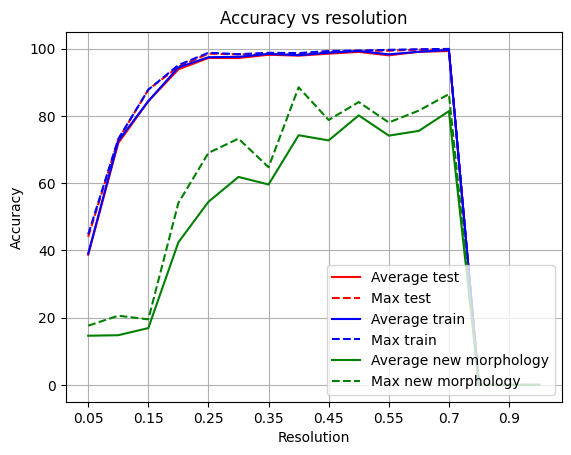

In [8]:
average_test=np.average(scores_test,axis=1)*100
max_test=np.max(scores_test,axis=1)*100
average_train=np.average(scores_train,axis=1)*100
max_train=np.max(scores_train,axis=1)*100
average_NM=np.average(scores_test_NM,axis=1)*100
max_NM=np.max(scores_test_NM,axis=1)*100


plt.plot(average_test,c="r",label="Average test")
plt.plot(max_test,"--",c="r",label="Max test")
plt.ylabel("Accuracy")
plt.plot(average_train,c="b",label="Average train")
plt.plot(max_train,"--",c="b",label="Max train")
plt.title("Accuracy vs resolution")
plt.plot(average_NM,c="g",label="Average new morphology")
plt.plot(max_NM,"--",c="g",label="Max new morphology")
plt.grid(True)
plt.xticks([i for i in range(0,len(resolutions),2)],labels=[resolutions[i] for i in range(0,len(resolutions),2)])
plt.xlabel("Resolution")
plt.legend(loc="lower right")
plt.savefig(path+"/images/NM_resolution_uber.pdf")
plt.show()

### LSTM train

In [9]:
torch.cuda.empty_cache()
train_loader,test_loader,unique=genLSTMData(0,4)
model,history=runLSTM(train_loader,0,4)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodel_lstm")

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 12.0 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_16952\4260854817.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 451.2954
Epoch [11/100], Step [180/180], Loss: 99.3751
Epoch [21/100], Step [180/180], Loss: 19.1849
Epoch [31/100], Step [180/180], Loss: 6.0299
Epoch [41/100], Step [180/180], Loss: 3.0394
Epoch [51/100], Step [180/180], Loss: 1.9189
Epoch [61/100], Step [180/180], Loss: 1.3619
Epoch [71/100], Step [180/180], Loss: 1.0403
Epoch [81/100], Step [180/180], Loss: 0.8327
Epoch [91/100], Step [180/180], Loss: 0.6897
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.99861093747829 %
0.9999861093747829


In [ ]:
#CNN
torch.cuda.empty_cache()
train_loader,test_loader,unique=genCNNLSTMData(0,4)

In [53]:
train_loader,test_loader,unique=genCNNLSTMData(0,4)
model,history=runLSTMcnn(train_loader,0,4,num_epochs=120)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/uber_lstmCNN")


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 25800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.27 GB
Memory left 12.0 GB
Using 10.15 GB
torch.Size([25799, 1, 4, 110, 120])
torch.Size([25799, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_13128\3960679742.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/120], Step [516/516], Loss: 1252.3793
Epoch [11/120], Step [516/516], Loss: 50.8115
Epoch [21/120], Step [516/516], Loss: 28.7570
Epoch [31/120], Step [516/516], Loss: 21.7160
Epoch [41/120], Step [516/516], Loss: 18.2610
Epoch [51/120], Step [516/516], Loss: 14.2798
Epoch [61/120], Step [516/516], Loss: 11.0768
Epoch [71/120], Step [516/516], Loss: 6.9041
Epoch [81/120], Step [516/516], Loss: 5.1442
Epoch [91/120], Step [516/516], Loss: 3.5459
Epoch [101/120], Step [516/516], Loss: 3.0974
Epoch [111/120], Step [516/516], Loss: 2.0778
Finished Training
Accuracy: 99.92054417550047 %
0.9992054417550047
Accuracy: 99.99951548274876 %
0.9999951548274877


In [21]:
torch.save(model.state_dict(), path+"/model/mymodel_lstm_cnn")
print(calc(model,test_loader))
print(calc(model,train_loader))

Accuracy: 98.43897561246598 %
0.9843897561246598
Accuracy: 98.73456404272756 %
0.9873456404272756


### Look at resolution

In [ ]:
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
test_scores=np.zeros((len(resolutions),5))
train_scores=np.zeros((len(resolutions),5))
for i,res in enumerate(resolutions):
    print("RESOLUTIONS",i,"/",len(resolutions))
    for trial in range(5):
        train_loader,test_loader,unique=genData(0,4,res)
        model,history=run(train_loader,0,4)
        test_scores[i][trial]=calc(model,test_loader)
        train_scores[i][trial]=calc(model,train_loader)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/resolutions_train",train_scores)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/resolutions_test",test_scores)


In [18]:
image=next(iter(train_loader))
print(image[0][0][0].shape)

torch.Size([440, 120])


### Look at performance

In [ ]:
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=genData(0,4)
    model,history=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except MemoryError as e:
    try:
        del train_loader
        del test_loader
        del model
    except: 
        pass
    

In [7]:
#3d 
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=gen3DData(0,4)
    model,history=run3D(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except Exception as e:
    print(e)
    del train_loader
    del test_loader
    del model


Dataset size: 7600 
Window size: 20 
Image: (110, 120)
Memory needed: 1.87 GB
Dataset size: 22800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.12 GB
NEW SIZE (7600, 4, 110, 120)
Memory left 1.93 GB
Using 1.79 GB
torch.Size([4560, 1, 4, 110, 120])
torch.Size([4560, 13])


/tmp/ipykernel_4785/3315938198.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [92/92], Loss: 234.3537
Epoch [11/100], Step [92/92], Loss: 48.3510
Epoch [21/100], Step [92/92], Loss: 23.0498
Epoch [31/100], Step [92/92], Loss: 13.9282
Epoch [41/100], Step [92/92], Loss: 10.5324
Epoch [51/100], Step [92/92], Loss: 6.9935
Epoch [61/100], Step [92/92], Loss: 5.3027
Epoch [71/100], Step [92/92], Loss: 4.5608
Epoch [81/100], Step [92/92], Loss: 3.5445
Epoch [91/100], Step [92/92], Loss: 4.2081
Finished Training
Accuracy: 98.34447977195482 %
0.9834447977195483
Accuracy: 98.37997861900716 %
0.9837997861900716


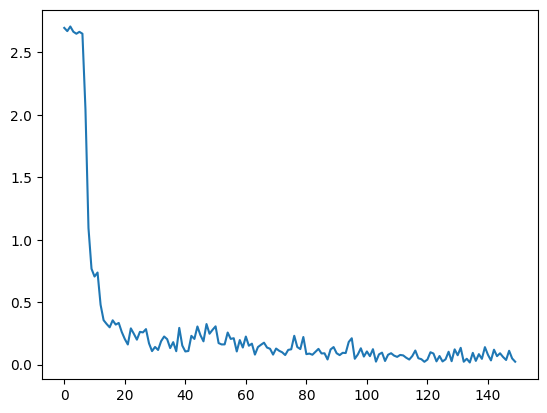

TypeError: save() missing 1 required positional argument: 'arr'

In [52]:
plt.plot(history)
plt.show()
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/ubermodellstmcnn.pdf")

(1092,) (1092,)


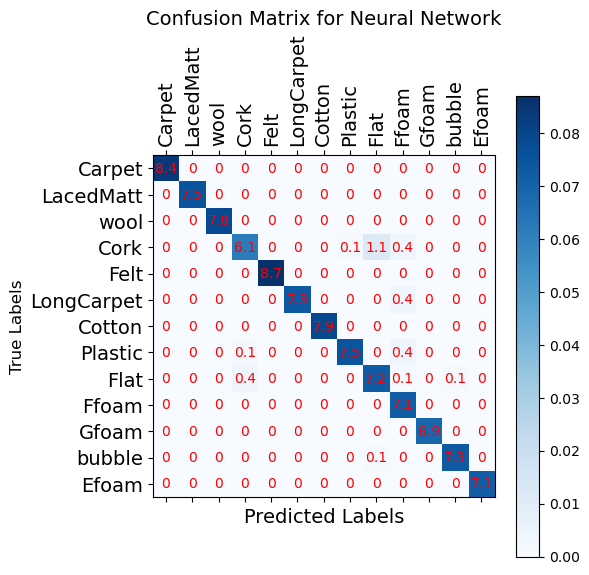

In [10]:
preds=None
real=None
keys=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'Cotton', 'Plastic', 'Flat', 'Ffoam', 'Gfoam', 'bubble', 'Efoam', 'Jeans', 'Leather']
for i, (inputs, labels) in enumerate(test_loader):
    outputs = model(inputs)
    a=torch.argmax(outputs.detach(),axis=1)
    if type(preds)==type(None):
        preds=a.numpy().copy()
        real=np.argmax(labels.numpy().copy(),axis=1)
    else:
        preds=np.concatenate([preds,a.numpy().copy()])
        real=np.concatenate([real,np.argmax(labels.numpy().copy(),axis=1)])


def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(real)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

print(real.shape,preds.shape)
# Combine all predictions
predictions = [preds]
model_names = ['Neural Network']
num_classes = len(np.unique(real))
un=np.unique(real)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(real, preds, num_classes=len(np.unique(real)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100) if round(value*100,1) == 0.0 else round(value*100,1)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([keys[unique[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([keys[unique[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig(path+"/images/NM_confusionCNN.pdf")
plt.show()

In [31]:
torch.save(model.state_dict(), "C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel")


In [6]:
model = SimpleCNN(abs(0-4)*110,120,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

RuntimeError: Error(s) in loading state_dict for SimpleCNN:
	size mismatch for conv2.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([10, 32, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 211200]) from checkpoint, the shape in current model is torch.Size([128, 33000]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([13, 128]) from checkpoint, the shape in current model is torch.Size([15, 128]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([15]).

In [15]:
#perform on unseen pressures

#load in numpy
data=np.load(datapath+"datasets/X_texture_pout.npz")
for array_name in data:
    x_unseen=(data[array_name].astype(np.uint8))
data=np.load(datapath+"datasets/y_texture_pout.npz")
for array_name in data:
    y_unseen=(data[array_name].astype(np.uint8))
print(x_unseen.shape)
#cut temporal size
x_unseen=x_unseen[:,0:4]
X=np.zeros_like(x_unseen)
#apply sobel filter
for i in range(len(x_unseen)): #crop all images individually
    for j in range(len(x_unseen[0])):
        image=x_unseen[i][j]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i][j]=sobel_combined
unique_=["Flat","wool","Efoam","LongCarpet","LacedMatt","cotton","Gfoam","Carpet","felt","Ffoam","bubble","Cork","Jeans"]
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
        
unique_={i:keys[unique_[i]] for i in range(len(unique_))}

#concat
X=X.reshape((4,len(X)//4,1,abs(0-4)*110,120))
X=torch.tensor(X, dtype=torch.float32).to(device)
y=y_unseen.reshape(4,len(y_unseen)//4)
print(X.shape,unique_)
#run through model
predsA=torch.argmax(model(X[0]),axis=1).detach().numpy()
predsB=torch.argmax(model(X[1]),axis=1).detach().numpy()
predsC=torch.argmax(model(X[2]),axis=1).detach().numpy()
predsD=torch.argmax(model(X[3]),axis=1).detach().numpy()
data=np.array([predsA,predsB,predsC,predsD])
for i,batch in enumerate(data):
    for key in np.unique(batch):
        batch[batch==key]=unique_[key]
data=data.reshape((len(x_unseen)))
y=y.reshape((len(x_unseen)))

#show accuracy (maybe confusion matrix of sorts)
correct=0
summed=0.1
a=data==y
summed+=len(x_unseen)
correct+=len(a[a==1])
print("Accuracy:",(correct/summed)*100,"%")

(800, 20, 110, 120)
torch.Size([4, 200, 1, 440, 120]) {0: 16, 1: 19, 2: 21, 3: 25, 4: 28, 5: 29, 6: 30, 7: 31, 8: 34, 9: 36, 10: 37, 11: 38, 12: 39}
Accuracy: 99.9875015623047 %


# Vis

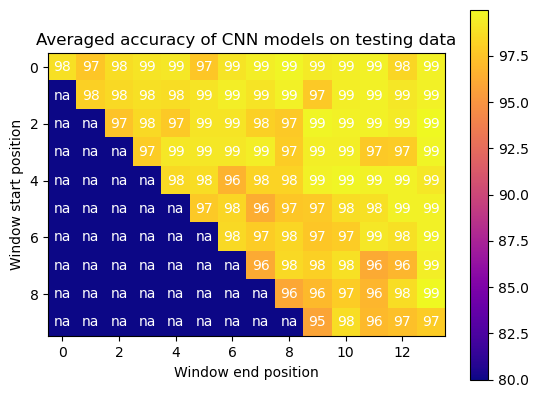

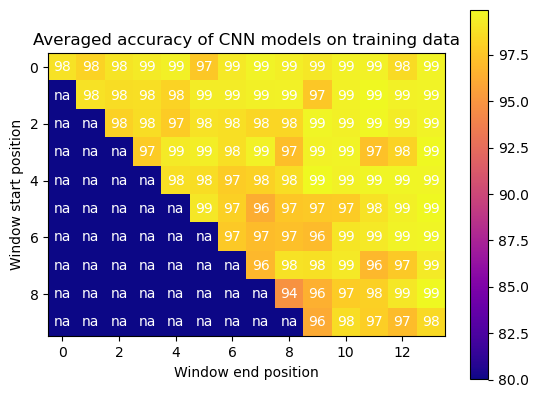

In [16]:
test=np.load(path+"saves/test_scores.npy")
train=np.load(path+"saves/train_scores.npy")

test=np.max(test,axis=2)*100
"""test=(test-np.min(test))/(np.max(test)-np.min(test))
test*=255"""
test[test==0]=80
plt.imshow(test,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        num=int(test[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')

plt.title("Averaged accuracy of CNN models on testing data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()



train=np.max(train,axis=2)*100
train[train==0]=80
plt.imshow(train,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        num=int(train[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')
plt.title("Averaged accuracy of CNN models on training data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()

## Feature layer

In [13]:
data=loaded(4,filename="X_data_newMorph.npz")
data.applySobel()
sample_of_data=data.X[0:10]

model = SimpleCNN(abs(4)*data.X.shape[2],data.X.shape[3],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel"))
model.eval()


x_data=data.X[0:4].reshape((len(data.X[0:4]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data))
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB


(110, 30)


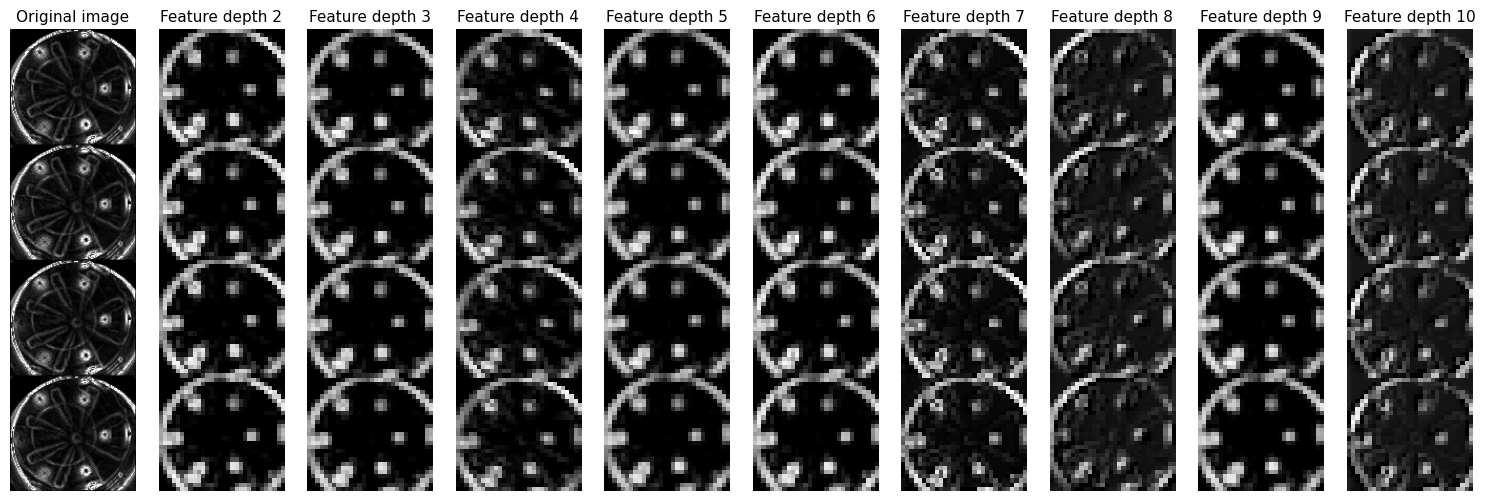

In [12]:

#forward pass
x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
print(x[0][0].shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(train_images_tensor[0][0].cpu().detach().numpy(),cmap="gray")
axes[0].axis("off")
axes[0].set_title("Original image",fontsize=11)
for i in range(1,10):
    axes[i].imshow(x[2][i],cmap="gray")
    axes[i].axis("off")
    axes[i].set_title("Feature depth "+str(i+1),fontsize=11)
plt.tight_layout()
plt.savefig(path+"images/featuresALL_uberModel.pdf")
plt.show()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
(9000, 52800)


/its/home/drs25/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/its/home/drs25/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


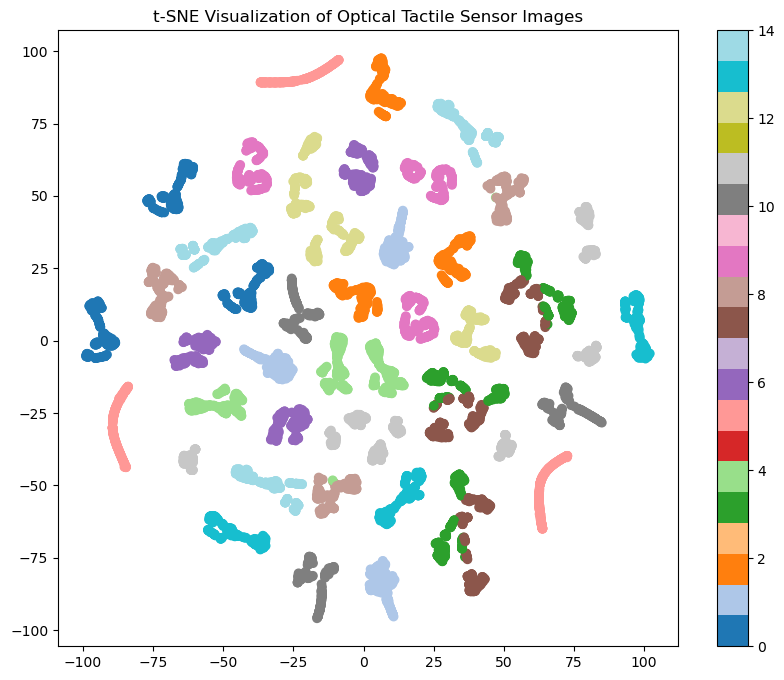

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data=loaded(t=4)
data.applySobel()
data.augment()

# Reduce dimensionality with PCA
pca = PCA(n_components=833)
x_data=data.X[0:].reshape((len(data.X[0:]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
labels=data.y[0:]
print(x_data.reshape(len(x_data), -1).shape)
pca_features = pca.fit_transform(x_data.reshape(len(x_data), -1))

# Further reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title('t-SNE Visualization of Optical Tactile Sensor Images')
plt.savefig(path+"/images/clusters.pdf")
plt.show()

# Point prediction

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()

# Just points

In [47]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=5)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


(3000, 5, 110, 120)
(3000, 5, 110, 120) (3000, 5, 260, 270)


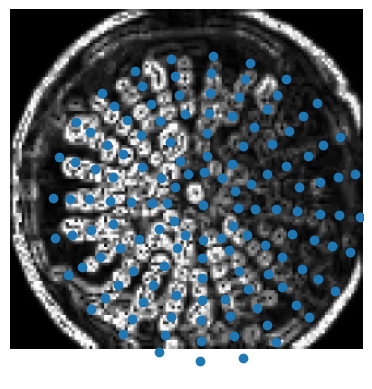

In [48]:
sample=data.X
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()
del sample
del X_prime
del X_alt

## FNN

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_layer1_size)
        
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)


        self.fc3 = nn.Linear(hidden_layer2_size, 50)
        
        # Define the output fully connected layer
        self.fc4 = nn.Linear(50, output_size)
    
    def forward(self, x):
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        # Apply the output fully connected layer
        x = self.fc4(x)
        
        return x


In [99]:
X = np.round(coords.reshape((len(coords),-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
hidden_layer1_size = len(X[0]) //2  # Number of neurons in the first hidden layer
hidden_layer2_size = 800  # Number of neurons in the second hidden layer
output_size = len(un)     # Number of output features

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Print the model architecture
print(model)
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print(X.shape,y.shape,X.dtype,y.dtype)
# Create a TensorDataset and DataLoader
#dataset = TensorDataset(torch.Tensor(train_X).to(device), torch.Tensor(train_y).to(device))
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


SimpleNeuralNetwork(
  (fc1): Linear(in_features=1330, out_features=665, bias=True)
  (fc2): Linear(in_features=665, out_features=800, bias=True)
  (fc3): Linear(in_features=800, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=15, bias=True)
)
(3000, 1330) (3000, 15) float64 float64
Epoch [1/10000], Loss: 2.7115
Epoch [101/10000], Loss: 2.7079
Epoch [201/10000], Loss: 2.7067
Epoch [301/10000], Loss: 2.7059
Epoch [401/10000], Loss: 2.7050
Epoch [501/10000], Loss: 2.7038
Epoch [601/10000], Loss: 2.7015
Epoch [701/10000], Loss: 2.6968
Epoch [801/10000], Loss: 2.6842
Epoch [901/10000], Loss: 2.6351
Epoch [1001/10000], Loss: 2.7024
Epoch [1101/10000], Loss: 2.7108
Epoch [1201/10000], Loss: 2.5478
Epoch [1301/10000], Loss: 2.5203
Epoch [1401/10000], Loss: 2.8193
Epoch [1501/10000], Loss: 2.4334
Epoch [1601/10000], Loss: 2.5988
Epoch [1701/10000], Loss: 2.4162
Epoch [1801/10000], Loss: 2.4402
Epoch [1901/10000], Loss: 2.6450
Epoch [2001/10000], Loss: 2.6623
Epoch [210

In [100]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
39.666666666666664 %
(600, 15) (2400, 15)
42.375 %


In [16]:
coords.reshape((len(coords),-1)).shape

(3000, 1064)

## LSTM

In [15]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class SimpleLSTMDrop(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(SimpleLSTMDrop, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [102]:
X = np.round(coords.reshape((len(coords),5,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 100, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 5, 266) (3000, 15) float64 (2400, 5, 266)
Epoch [100/10000], Loss: 0.0622
Epoch [200/10000], Loss: 0.0608
Epoch [300/10000], Loss: 0.0579
Epoch [400/10000], Loss: 0.0578
Epoch [500/10000], Loss: 0.0578
Epoch [600/10000], Loss: 0.0578
Epoch [700/10000], Loss: 0.0578
Epoch [800/10000], Loss: 0.0578
Epoch [900/10000], Loss: 0.0576
Epoch [1000/10000], Loss: 0.0560
Epoch [1100/10000], Loss: 0.0541
Epoch [1200/10000], Loss: 0.0535
Epoch [1300/10000], Loss: 0.0531
Epoch [1400/10000], Loss: 0.0509
Epoch [1500/10000], Loss: 0.0494
Epoch [1600/10000], Loss: 0.0494
Epoch [1700/10000], Loss: 0.0493
Epoch [1800/10000], Loss: 0.0493
Epoch [1900/10000], Loss: 0.0493
Epoch [2000/10000], Loss: 0.0493
Epoch [2100/10000], Loss: 0.0482
Epoch [2200/10000], Loss: 0.0470
Epoch [2300/10000], Loss: 0.0461
Epoch [2400/10000], Loss: 0.0461
Epoch [2500/10000], Loss: 0.0459
Epoch [2600/10000], Loss: 0.0458
Epoch [2700/10000], Loss: 0.0485
Epoch [2800/10000], Loss: 0.0425
Epoch [2900/10000], Loss: 0.0415
Epo

In [104]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
11.833333333333334 %
(600, 15) (2400, 15)
13.750000000000002 %


# Point velocities

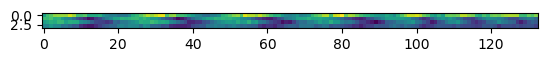

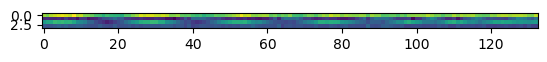

In [66]:
def plotchange(average):
    magnitudes=[]
    for t in range(len(average)-1):
        magnitudes.append(euclidean_distance(average[t],average[t+1]))
    ar=np.array(magnitudes).T
    return ar#(ar-np.min(ar))/(np.max(ar)-np.min(ar))

def euclidean_distance(point1, point2):
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    # Calculate the distance
    distance = np.linalg.norm(point1 - point2,axis=1)
    
    return distance

#create dataset
d1=coords[:,:-1,:]
d2=coords[:,1:,:]
distances=np.linalg.norm(d1 - d2,axis=3)



## LSTM

In [119]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1200

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 4, 133) (3000, 15) float64 (2400, 4, 133)
Epoch [10/1200], Loss: 0.0601
Epoch [20/1200], Loss: 0.0585
Epoch [30/1200], Loss: 0.0574
Epoch [40/1200], Loss: 0.0556
Epoch [50/1200], Loss: 0.0541
Epoch [60/1200], Loss: 0.0532
Epoch [70/1200], Loss: 0.0522
Epoch [80/1200], Loss: 0.0517
Epoch [90/1200], Loss: 0.0501
Epoch [100/1200], Loss: 0.0496
Epoch [110/1200], Loss: 0.0488
Epoch [120/1200], Loss: 0.0479
Epoch [130/1200], Loss: 0.0481
Epoch [140/1200], Loss: 0.0471
Epoch [150/1200], Loss: 0.0472
Epoch [160/1200], Loss: 0.0455
Epoch [170/1200], Loss: 0.0447
Epoch [180/1200], Loss: 0.0452
Epoch [190/1200], Loss: 0.0437
Epoch [200/1200], Loss: 0.0435
Epoch [210/1200], Loss: 0.0431
Epoch [220/1200], Loss: 0.0420
Epoch [230/1200], Loss: 0.0430
Epoch [240/1200], Loss: 0.0425
Epoch [250/1200], Loss: 0.0412
Epoch [260/1200], Loss: 0.0404
Epoch [270/1200], Loss: 0.0460
Epoch [280/1200], Loss: 0.0410
Epoch [290/1200], Loss: 0.0400
Epoch [300/1200], Loss: 0.0392
Epoch [310/1200], Loss: 0.0417

In [120]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
75.33333333333333 %
(600, 15) (2400, 15)
82.5 %


In [112]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTMDrop(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(3000, 4, 133) (3000, 15) float64 (2400, 4, 133)
Epoch [10/600], Loss: 0.0716
Epoch [20/600], Loss: 0.0620
Epoch [30/600], Loss: 0.0606
Epoch [40/600], Loss: 0.0597
Epoch [50/600], Loss: 0.0592
Epoch [60/600], Loss: 0.0587
Epoch [70/600], Loss: 0.0582
Epoch [80/600], Loss: 0.0576
Epoch [90/600], Loss: 0.0574
Epoch [100/600], Loss: 0.0562
Epoch [110/600], Loss: 0.0555
Epoch [120/600], Loss: 0.0546
Epoch [130/600], Loss: 0.0534
Epoch [140/600], Loss: 0.0525
Epoch [150/600], Loss: 0.0513
Epoch [160/600], Loss: 0.0504
Epoch [170/600], Loss: 0.0494
Epoch [180/600], Loss: 0.0478
Epoch [190/600], Loss: 0.0465
Epoch [200/600], Loss: 0.0457
Epoch [210/600], Loss: 0.0452
Epoch [220/600], Loss: 0.0442
Epoch [230/600], Loss: 0.0426
Epoch [240/600], Loss: 0.0416
Epoch [250/600], Loss: 0.0405
Epoch [260/600], Loss: 0.0418
Epoch [270/600], Loss: 0.0404
Epoch [280/600], Loss: 0.0395
Epoch [290/600], Loss: 0.0403
Epoch [300/600], Loss: 0.0369
Epoch [310/600], Loss: 0.0356
Epoch [320/600], Loss: 0.0375


## FNN

In [91]:
X = distances.reshape((len(distances),-1))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 532) (3000, 15) float64 (2400, 532)
Epoch [1/10000], Loss: 2.7142
Epoch [101/10000], Loss: 2.7056
Epoch [201/10000], Loss: 2.6937
Epoch [301/10000], Loss: 2.6629
Epoch [401/10000], Loss: 2.6000
Epoch [501/10000], Loss: 2.5020
Epoch [601/10000], Loss: 2.3986
Epoch [701/10000], Loss: 2.3170
Epoch [801/10000], Loss: 2.2641
Epoch [901/10000], Loss: 2.2318
Epoch [1001/10000], Loss: 2.2112
Epoch [1101/10000], Loss: 2.1969
Epoch [1201/10000], Loss: 2.1857
Epoch [1301/10000], Loss: 2.1760
Epoch [1401/10000], Loss: 2.1672
Epoch [1501/10000], Loss: 2.1587
Epoch [1601/10000], Loss: 2.1503
Epoch [1701/10000], Loss: 2.1420
Epoch [1801/10000], Loss: 2.1339
Epoch [1901/10000], Loss: 2.1257
Epoch [2001/10000], Loss: 2.1174
Epoch [2101/10000], Loss: 2.1090
Epoch [2201/10000], Loss: 2.1007
Epoch [2301/10000], Loss: 2.0924
Epoch [2401/10000], Loss: 2.0843
Epoch [2501/10000], Loss: 2.0761
Epoch [2601/10000], Loss: 2.0679
Epoch [2701/10000], Loss: 2.0596
Epoch [2801/10000], Loss: 2.0512
Epoch [2901/

In [92]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
34.833333333333336 %
(600, 15) (2400, 15)
35.833333333333336 %


## CNN

In [109]:
X = np.round(distances.reshape((len(distances),1,4,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleCNN(len(distances[0]),len(distances[0][0]))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 1, 4, 133) (3000, 15) float64 (2400, 1, 4, 133)
Epoch [10/10000], Loss: 0.0705
Epoch [20/10000], Loss: 0.0701
Epoch [30/10000], Loss: 0.0697
Epoch [40/10000], Loss: 0.0694
Epoch [50/10000], Loss: 0.0690
Epoch [60/10000], Loss: 0.0687
Epoch [70/10000], Loss: 0.0684
Epoch [80/10000], Loss: 0.0681
Epoch [90/10000], Loss: 0.0679
Epoch [100/10000], Loss: 0.0676
Epoch [110/10000], Loss: 0.0674
Epoch [120/10000], Loss: 0.0672
Epoch [130/10000], Loss: 0.0669
Epoch [140/10000], Loss: 0.0667
Epoch [150/10000], Loss: 0.0665
Epoch [160/10000], Loss: 0.0663
Epoch [170/10000], Loss: 0.0662
Epoch [180/10000], Loss: 0.0660
Epoch [190/10000], Loss: 0.0658
Epoch [200/10000], Loss: 0.0657
Epoch [210/10000], Loss: 0.0655
Epoch [220/10000], Loss: 0.0654
Epoch [230/10000], Loss: 0.0652
Epoch [240/10000], Loss: 0.0651
Epoch [250/10000], Loss: 0.0650
Epoch [260/10000], Loss: 0.0649
Epoch [270/10000], Loss: 0.0647
Epoch [280/10000], Loss: 0.0646
Epoch [290/10000], Loss: 0.0645
Epoch [300/10000], Loss: 0

In [111]:
inputs=torch.Tensor(test_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
14.666666666666666 %
(600, 15) (2400, 15)
16.416666666666664 %


In [107]:
np.save(path+"/data/distances",distances)
np.save(path+"/data/distancesy",data.y)

# Transferability of normal model 

In [10]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodelgel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()
            

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 2.48 GB
torch.Size([6300, 1, 440, 120])
torch.Size([6300, 15])


/tmp/ipykernel_64935/3189561383.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 328.2897
Epoch [11/100], Step [126/126], Loss: 21.4137
Epoch [21/100], Step [126/126], Loss: 3.7549
Epoch [31/100], Step [126/126], Loss: 0.9399
Epoch [41/100], Step [126/126], Loss: 0.2917
Epoch [51/100], Step [126/126], Loss: 0.1769
Epoch [61/100], Step [126/126], Loss: 0.1354
Epoch [71/100], Step [126/126], Loss: 0.1023
Epoch [81/100], Step [126/126], Loss: 0.0839
Epoch [91/100], Step [126/126], Loss: 0.0684
Finished Training


RuntimeError: Parent directory /model does not exist.

In [11]:

modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [22]:
print(calc(model,test_loader))
print(calc(model,train_loader))

import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p

Accuracy: 99.83334655979685 %
0.9983334655979685
Accuracy: 99.99801591238268 %
0.9999801591238269
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [13]:
sample=data.X[0:300]
X_prime=np.zeros((len(sample),sample.shape[1],*data.X[0][0].shape),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2)).astype(np.uint16)
divh=X_prime[0][0].shape[0]/270
divw=X_prime[0][0].shape[1]/260
print(divh,divw,X_prime[0][0].shape)
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        temp=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=np.round(predict(reg,temp)[0])
        #X_prime[i][j]*=0 
        for point in zip(coords[i][j][:,0],coords[i][j][:,1]):
            p1=int(point[0]*divh)
            p2=int(point[1]*divw)
            cv2.circle(X_prime[i][j],(p1,p2),1,(255),2)
del sample

0.4074074074074074 0.46153846153846156 (110, 120)


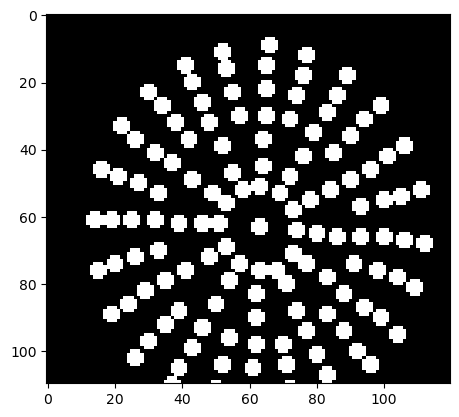

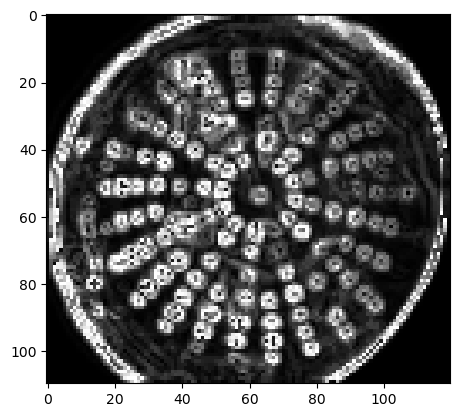

In [190]:
plt.imshow(X_prime[0][0],cmap="gray")
plt.show()
plt.imshow(data.X[0][0],cmap="gray")
plt.show()

In [49]:
x=(X_prime-np.mean(X_prime))/(np.max(X_prime)-np.min(X_prime))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
print(x.shape)
test=torch.tensor(x, dtype=torch.float32)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")


(300, 1, 440, 120)
torch.float32
6.0 %


## Taking out segments



In [18]:
data=loaded(4,filename="X_data_15.npz")
data.applySobel()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


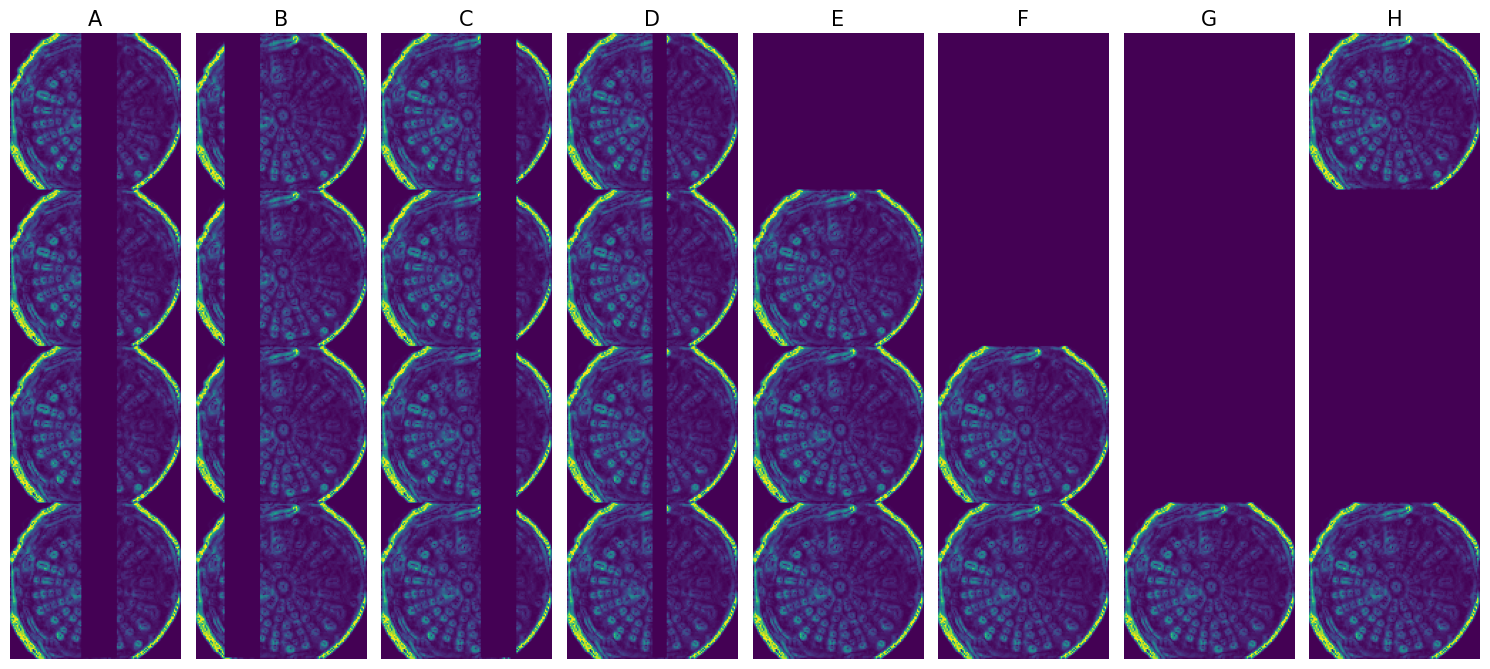

In [38]:

sample=data.X[0:300].reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
images=[sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy()]
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
label=["50:75","20:45","70:95","60:70","Segment removed","Two removed","Three removed","Only first and last"]
label=["A","B","C","D","E","F","G","H"]
sample[:,:,0:220,0:120]=0

fig, axes = plt.subplots(1, len(images), figsize=(15,8))
axes = axes.flatten()
for i in range(len(images)):
    axes[i].set_title(label[i],fontsize=15)
    axes[i].imshow(images[i])
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(path+"/images/samplesCrops_.pdf")
plt.show()


In [21]:

model=SimpleCNN(data.X.shape[2]*4,data.X.shape[3],15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [39]:
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
print(x.shape)
test=torch.tensor(x, dtype=torch.float32).to(device)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")

#None = 100%
#A = 52% 50:75
#B = 67% 20:45
#C = 79% 70:95
#D = 96% 60:70
#E = 94% first segment removed
#F = 64% first two removed
#G = 32% first three removed
#H = 83% only first and last

(300, 1, 440, 120)
torch.float32
55.666666666666664 %


# Different pressures

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodel_withLowPressure") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
print(calc(model,test_loader))
print(calc(model,train_loader))

In [11]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()
#print(calc(model,test_loader))
#print(calc(model,train_loader))

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


SimpleLSTM(
  (lstm): LSTM(13200, 1000, batch_first=True)
  (fc): Linear(in_features=1000, out_features=15, bias=True)
)

In [12]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
d.applySobel()
sample=d.X
label=d.y


Dataset size: 800 
Window size: 20 
Image: (110, 120)
Memory needed: 0.2 GB


In [14]:
sample=d.X
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),x.shape[1],x.shape[2]*x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds[preds==11]
print(len(a)/len(preds) *100,"%")
del test
del x

100.0 %


In [16]:
p20=d.X[np.where(d.y==3)]
p30=d.X[np.where(d.y==0)]
p40=d.X[np.where(d.y==2)]
p50=d.X[np.where(d.y==1)]
data=[p20,p30,p40,p50]
accs=[]
for i in range(4):
    sample=data[i]
    label=11
    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))  #n,1,t*h,w for cnn, n,t,h*w for lstm, n,1,t,h,w for cnn-lstm
    test=torch.tensor(x, dtype=torch.float32).to(device)
    preds=model(test)
    preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
    a=len(preds[preds==label])
    print(a/len(preds) *100,"%")

ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

# models on other data sets

In [6]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0].copy()
del data
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#print(calc(model,test_loader))
#print(calc(model,train_loader))

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [7]:
model=SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)
#model=CNN_LSTM(image.shape[1],image.shape[0],1000,1,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [8]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_data_gel_15.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
sample=d.X[0:400]
label=d.y[0:400]
del d
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds-label
print(len(a[a==0])/len(preds) *100,"%")
del test
del x


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
99.25 %


# Transferring large models to small

In [6]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [17]:
d=loaded(t=4,filename="X_data_15.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
d.resize(0.1)

sample=d.X
sampley=d.y
image=sample[0][0]
print(image.shape)
#copy over correct convolutions
modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],15).to(device)
modelB.conv1=model.conv1
modelB.conv2=model.conv2
#freeze conv layers
modelB.conv1.requires_grad=False
modelB.conv2.requires_grad=False


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(11, 12)


In [18]:


label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(sampley)
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)


/tmp/ipykernel_15726/3748773328.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


In [19]:
#train
train_history=[]
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(modelB.parameters(), lr=0.005)

# Train the Model
num_epochs=50
clip_value = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = modelB(inputs)
        #print(inputs.shape,outputs.shape,labels.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    train_history.append(loss.cpu().detach().numpy())
    if epoch%10==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
print('Finished Training')

Epoch [1/50], Step [60/60], Loss: 148.3680
Epoch [11/50], Step [60/60], Loss: 71.8048
Epoch [21/50], Step [60/60], Loss: 53.7685
Epoch [31/50], Step [60/60], Loss: 44.4859
Epoch [41/50], Step [60/60], Loss: 35.9675
Finished Training


In [20]:
print(calc(modelB,test_loader))
print(calc(modelB,train_loader))

Accuracy: 85.48575237460423 %
0.8548575237460423
Accuracy: 87.37135952668639 %
0.8737135952668639


In [ ]:
#GEL
# 5%
# train % 58.95 test 57.99 % 

#10%
# train % 91.70 test 92.81 % 

#15%
# train % 93.37 test 94.81

#20%
# train % 96.99 test 98.15

#25%
# train % 99.9 test 99.98 % 

#NEWMORPH
# 5%
# train % 74.32 test 75.37 % 

#10%
# train % 89.17 test 89.02 % 

#15%
# train % 82.92 test 84.98 %

#20%
# train % 96.87 test 95.75 %

#25%
# train % 90.1 test 88.25 % 

#SILICONE
# 5%
# train % - test - % 

#10%
# train % - test - % 

#15%
# train % 79 test 74 %

#20%
# train % 88 test 90 %

#25%
# train % - test - % 

## automate

In [12]:
#automate the shit out of it
def long(file,type1,num):
    resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
    acc_test=np.zeros((len(resolution),5))
    acc_train=np.zeros((len(resolution),5))
    num_epochs=80
    history=np.zeros((len(resolution),5,num_epochs))

    for i in range(len(resolution)):
        d=loaded(t=4,filename=file) #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
        d.applySobel()
        image=d.X[0][0]
        model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
        model.load_state_dict(torch.load(path+"/model/mymodelgel"))
        model.eval()
        d.resize(resolution[i])
        
        sample=d.X
        sampley=d.y
        image=sample[0][0]
        print(image.shape)
        
        #copy over correct convolutions
        modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],num).to(device)
        modelB.conv1=model.conv1
        modelB.conv2=model.conv2
        #freeze conv layers
        modelB.conv1.requires_grad=False
        modelB.conv2.requires_grad=False


        label_encoder = LabelEncoder()
        train_labels_encoded = label_encoder.fit_transform(sampley)
        one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
        x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
        x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

        train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

        # Create a TensorDataset
        dataset = TensorDataset(train_images_tensor, train_labels_tensor)
        # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create DataLoader for training and testing sets
        train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
        max_=0
        for j in range(5):
            clear_output(wait=True)
            print("Resolution",resolution[i],"Trial",j)
            criterion = nn.CrossEntropyLoss().to(device)
            optimizer = optim.SGD(modelB.parameters(), lr=0.005)

            # Train the Model
            
            clip_value = 5
            for epoch in range(num_epochs):
                running_loss = 0.0
                for k, (inputs, labels) in enumerate(train_loader):
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = modelB(inputs)
                    #print(inputs.shape,outputs.shape,labels.shape)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
                    optimizer.step()

                    # Print statistics
                    running_loss += loss.item()
                history[i][j][epoch]=running_loss/(k+1) #save average loss per epoch
            test=calc(modelB,test_loader)
            train=calc(modelB,train_loader)
            acc_train[i][j]=train
            acc_test[i][j]=test
            if test>max_:
                max_=test
                torch.save(modelB.state_dict(), path+"/model/standard_c_gel/cnn_res"+str(resolution[i])+"_"+str(type1))
        del train_loader
        del test_loader
    
    np.save(path+"/data/train_uber_"+type1+"_long_standard_c",acc_train)
    np.save(path+"/data/test_uber_"+type1+"_long_standard_c",acc_test)
    np.save(path+"/data/histroy_"+type1+"_long_standard_c",history)

#X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
long("X_data_gel_15.npz","gel",15)
#long("X_data_15.npz","sil",15)
#long("X_data_newMorph.npz","nm",13)


Resolution 0.8 Trial 4
Accuracy: 99.98333611064822 %
Accuracy: 99.99583350693722 %


## vis

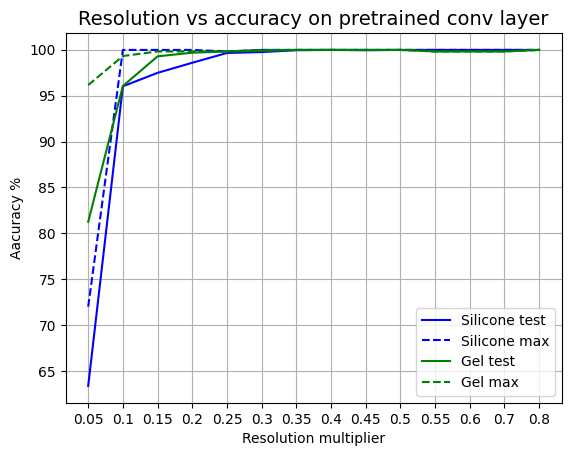

In [14]:
sil_train=np.load(path+"/data/train_uber_sil_long_standard_c.npy")
sil_test=np.load(path+"/data/test_uber_sil_long_standard_c.npy")
gel_train=np.load(path+"/data/train_uber_gel_long_standard_c.npy")
gel_test=np.load(path+"/data/test_uber_gel_long_standard_c.npy")
#nm_train=np.load(path+"/data/train_uber_nm_long.npy")
#nm_test=np.load(path+"/data/test_uber_nm_long.npy")

average_sil_test=np.average(sil_test,axis=1)*100
max_sil_test=np.max(sil_test,axis=1)*100
average_sil_train=np.average(sil_train,axis=1)*100
average_gel_test=np.average(gel_test,axis=1)*100
max_gel_test=np.max(gel_test,axis=1)*100
average_gel_train=np.average(gel_train,axis=1)*100
#average_nm_test=np.average(nm_test,axis=1)*100
#max_nm_test=np.max(nm_test,axis=1)*100
#average_nm_train=np.average(nm_train,axis=1)*100

plt.plot(average_sil_test,c="b",label="Silicone test")
plt.plot(max_sil_test,"--",c="b",label="Silicone max")
plt.plot(average_gel_test,c="g",label="Gel test")
plt.plot(max_gel_test,"--",c="g",label="Gel max")
#plt.plot(average_nm_test,c="r",label="NM test")
#plt.plot(max_nm_test,"--",c="r",label="NM max")

#plt.plot(average_sil_train,c="b",label="Silicone train")
resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
plt.xticks([i for i in range(len(resolution))],resolution)
plt.ylabel("Aacuracy %")
plt.xlabel("Resolution multiplier")
plt.title("Resolution vs accuracy on pretrained conv layer",fontsize=14)
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig(path+"/images/resolution_just_own_transfer.pdf")
plt.show()

(14, 5, 80)
(14, 80)


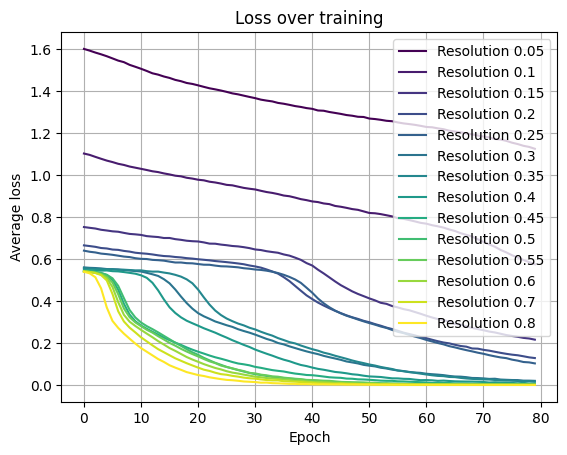

In [113]:
import matplotlib.cm as cm

sil_history=np.load(path+"/data/histroy_sil_long_untrained.npy")
gel_history=np.load(path+"/data/histroy_gel_long_untrained.npy")
nm_history=np.load(path+"/data/histroy_nm_long_untrained.npy")
print(sil_history.shape)

sil_history_av=np.average(sil_history,axis=1)
#gel_history_av=np.average(gel_history,axis=1)
#nm_history_av=np.average(nm_history,axis=1)
print(sil_history_av.shape)
# Create a colormap that gets darker
colors = cm.viridis(np.linspace(0, 1, len(resolution)))

for i in range(len(sil_history_av)):
    plt.plot(sil_history_av[i],color=colors[i],label="Resolution "+str(resolution[i]))
#plt.plot(gel_history_av,label="Average loss gel")
#plt.plot(nm_history_av,label="Average loss new morphology")
plt.title("Loss over training")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig(path+"/images/resolution_loss_untrained.pdf")
plt.show()

## Feature layers

In [15]:
images_X=[]
images_f=[]
images_o=[]
for i in range(len(resolution)-1):
    filename="cnn_res"+str(resolution[i])+"_gel"

    data=loaded(4,filename="X_data_15.npz")
    data.applySobel()
    data.resize(resolution[i])
    image=data.X[0][0]

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/res/"+filename))
    model.eval()

    sample=data.X[0:13]
    sampley=data.y[0:13]

    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

    train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_X.append(train_images_tensor[0][0].cpu().detach().numpy())
    images_f.append(x.copy())

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/learnedres/"+filename))
    model.eval()

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_o.append(x.copy())


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory ne

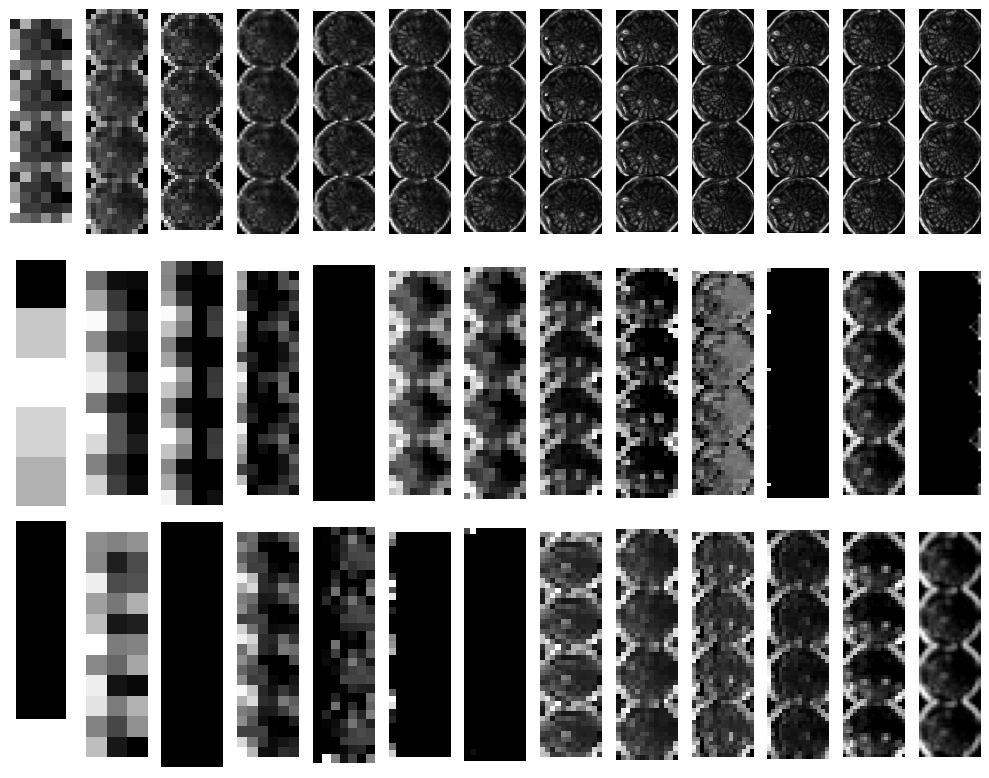

In [17]:

fig, axes = plt.subplots(3, len(resolution)-1, figsize=(10, 8))
#axes = axes.flatten()

for i in range(len(images_X)):
    axes[0][i].imshow(images_X[i],cmap="gray")
    axes[0][i].axis("off")
    axes[0][i].set_ylabel("Original res "+str(resolution[i]),fontsize=11)
    #print(images_f[i][0].shape)
    axes[1][i].imshow(images_f[i][0][0],cmap="gray")
    axes[1][i].axis("off")
    #axes[1][i].set_title("Feature res"+str(resolution[i]),fontsize=11)
    axes[2][i].imshow(images_o[i][1][0],cmap="gray")
    axes[2][i].axis("off")

plt.tight_layout()
plt.savefig(path+"images/features_norm_transfer.pdf")
plt.show()